In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from myfunctions import prediction_matrices

import warnings
warnings.filterwarnings("ignore")

In [105]:
df_train = pd.read_pickle('./data/df_train_dt.pkl')
df_test = pd.read_pickle('./data/df_test_dt.pkl')

# Assign Target and Features

In [106]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

In [107]:
#X_train_train = X_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

In [108]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

## Prediction on test data

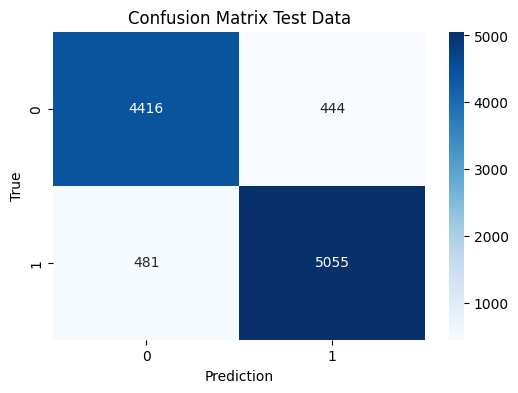

In [109]:
# Make predictions for test set
y_pred = clf.predict(X_test)

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix Test Data')
plt.show()

## Prediction on train data

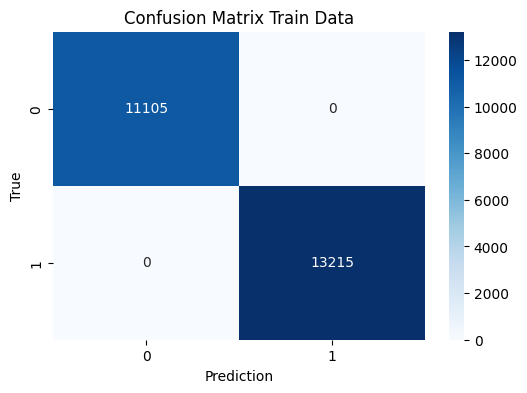

In [110]:
# Make predictions for train set
y_pred_train = clf.predict(X_train)

#confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix Train Data')
plt.show()

Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11105
           1       1.00      1.00      1.00     13215

    accuracy                           1.00     24320
   macro avg       1.00      1.00      1.00     24320
weighted avg       1.00      1.00      1.00     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.91
ROC on test set: 0.91
Report on test set : 
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      4860
           1       0.92      0.91      0.92      5536

    accuracy                           0.91     10396
   macro avg       0.91      0.91      0.91     10396
weighted avg       0.91      0.91      0.91     10396



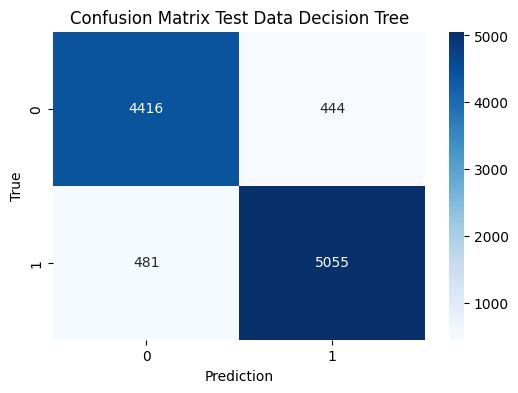

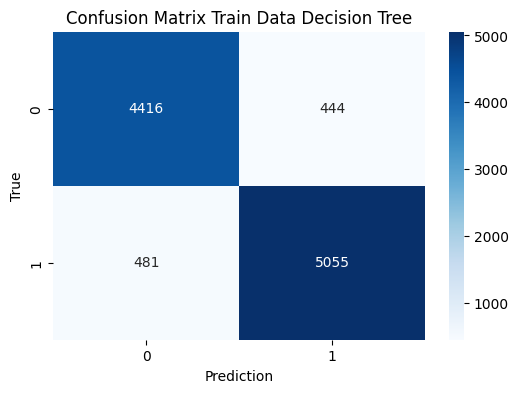

In [129]:
#plot predictio matrices
prediction_matrices(model = clf, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "Decision Tree")

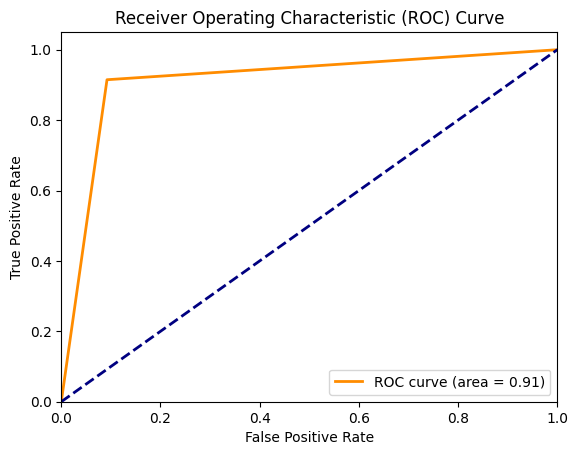

In [ ]:
# ROC Curve
y_pred_roc = clf.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save model
with open('./model/model_dectree.pkl', 'wb') as file:
    pickle.dump(clf, file)

## Feature Importance

In [ ]:
# Abrufen der Feature Importance
importances = clf.feature_importances_

# Ausgabe der Feature Importance
for feature, importance in zip(df_train.columns, importances):
    print(f"{feature}: {importance}")

gender_M: 0.0019265815045989207
gender_Unknown: 0.00015451901622738986
region_category_Town: 0.002448225650764911
region_category_Unknown: 0.002023898023635139
region_category_Village: 0.0022835270296897026
joined_through_referral_Unknown: 0.0008421377010611179
joined_through_referral_Yes: 0.0013308558712100298
preferred_offer_types_Gift Vouchers/Coupons: 0.0009694000782842973
preferred_offer_types_Without Offers: 0.0011485285881356665
medium_of_operation_Both: 0.0010778768717052394
medium_of_operation_Desktop: 0.0019643594523558305
medium_of_operation_Smartphone: 0.0026155159183391704
internet_option_Mobile_Data: 0.000978325922346221
internet_option_Wi-Fi: 0.002472618507102213
used_special_discount_Yes: 0.0036148349392006417
complaint_status_Not Applicable: 0.0009621976122030435
complaint_status_Solved: 0.0011904238850228269
complaint_status_Solved in Follow-up: 0.0011153586933831323
complaint_status_Unsolved: 0.0009226773955219862
feedback_Poor Customer Service: 0.0021853481357488524

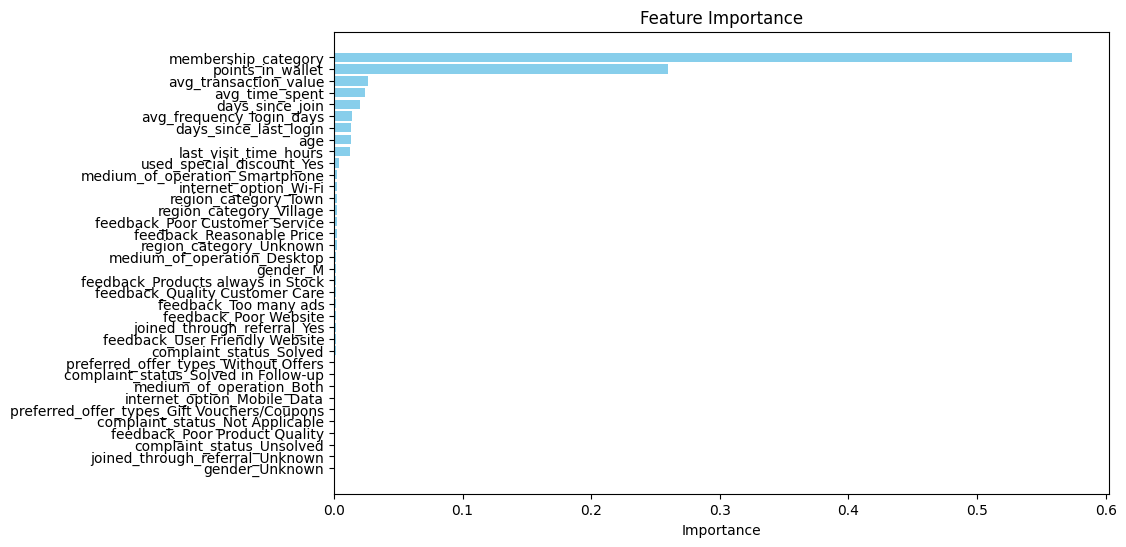

In [ ]:
#feature importance

importances = clf.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

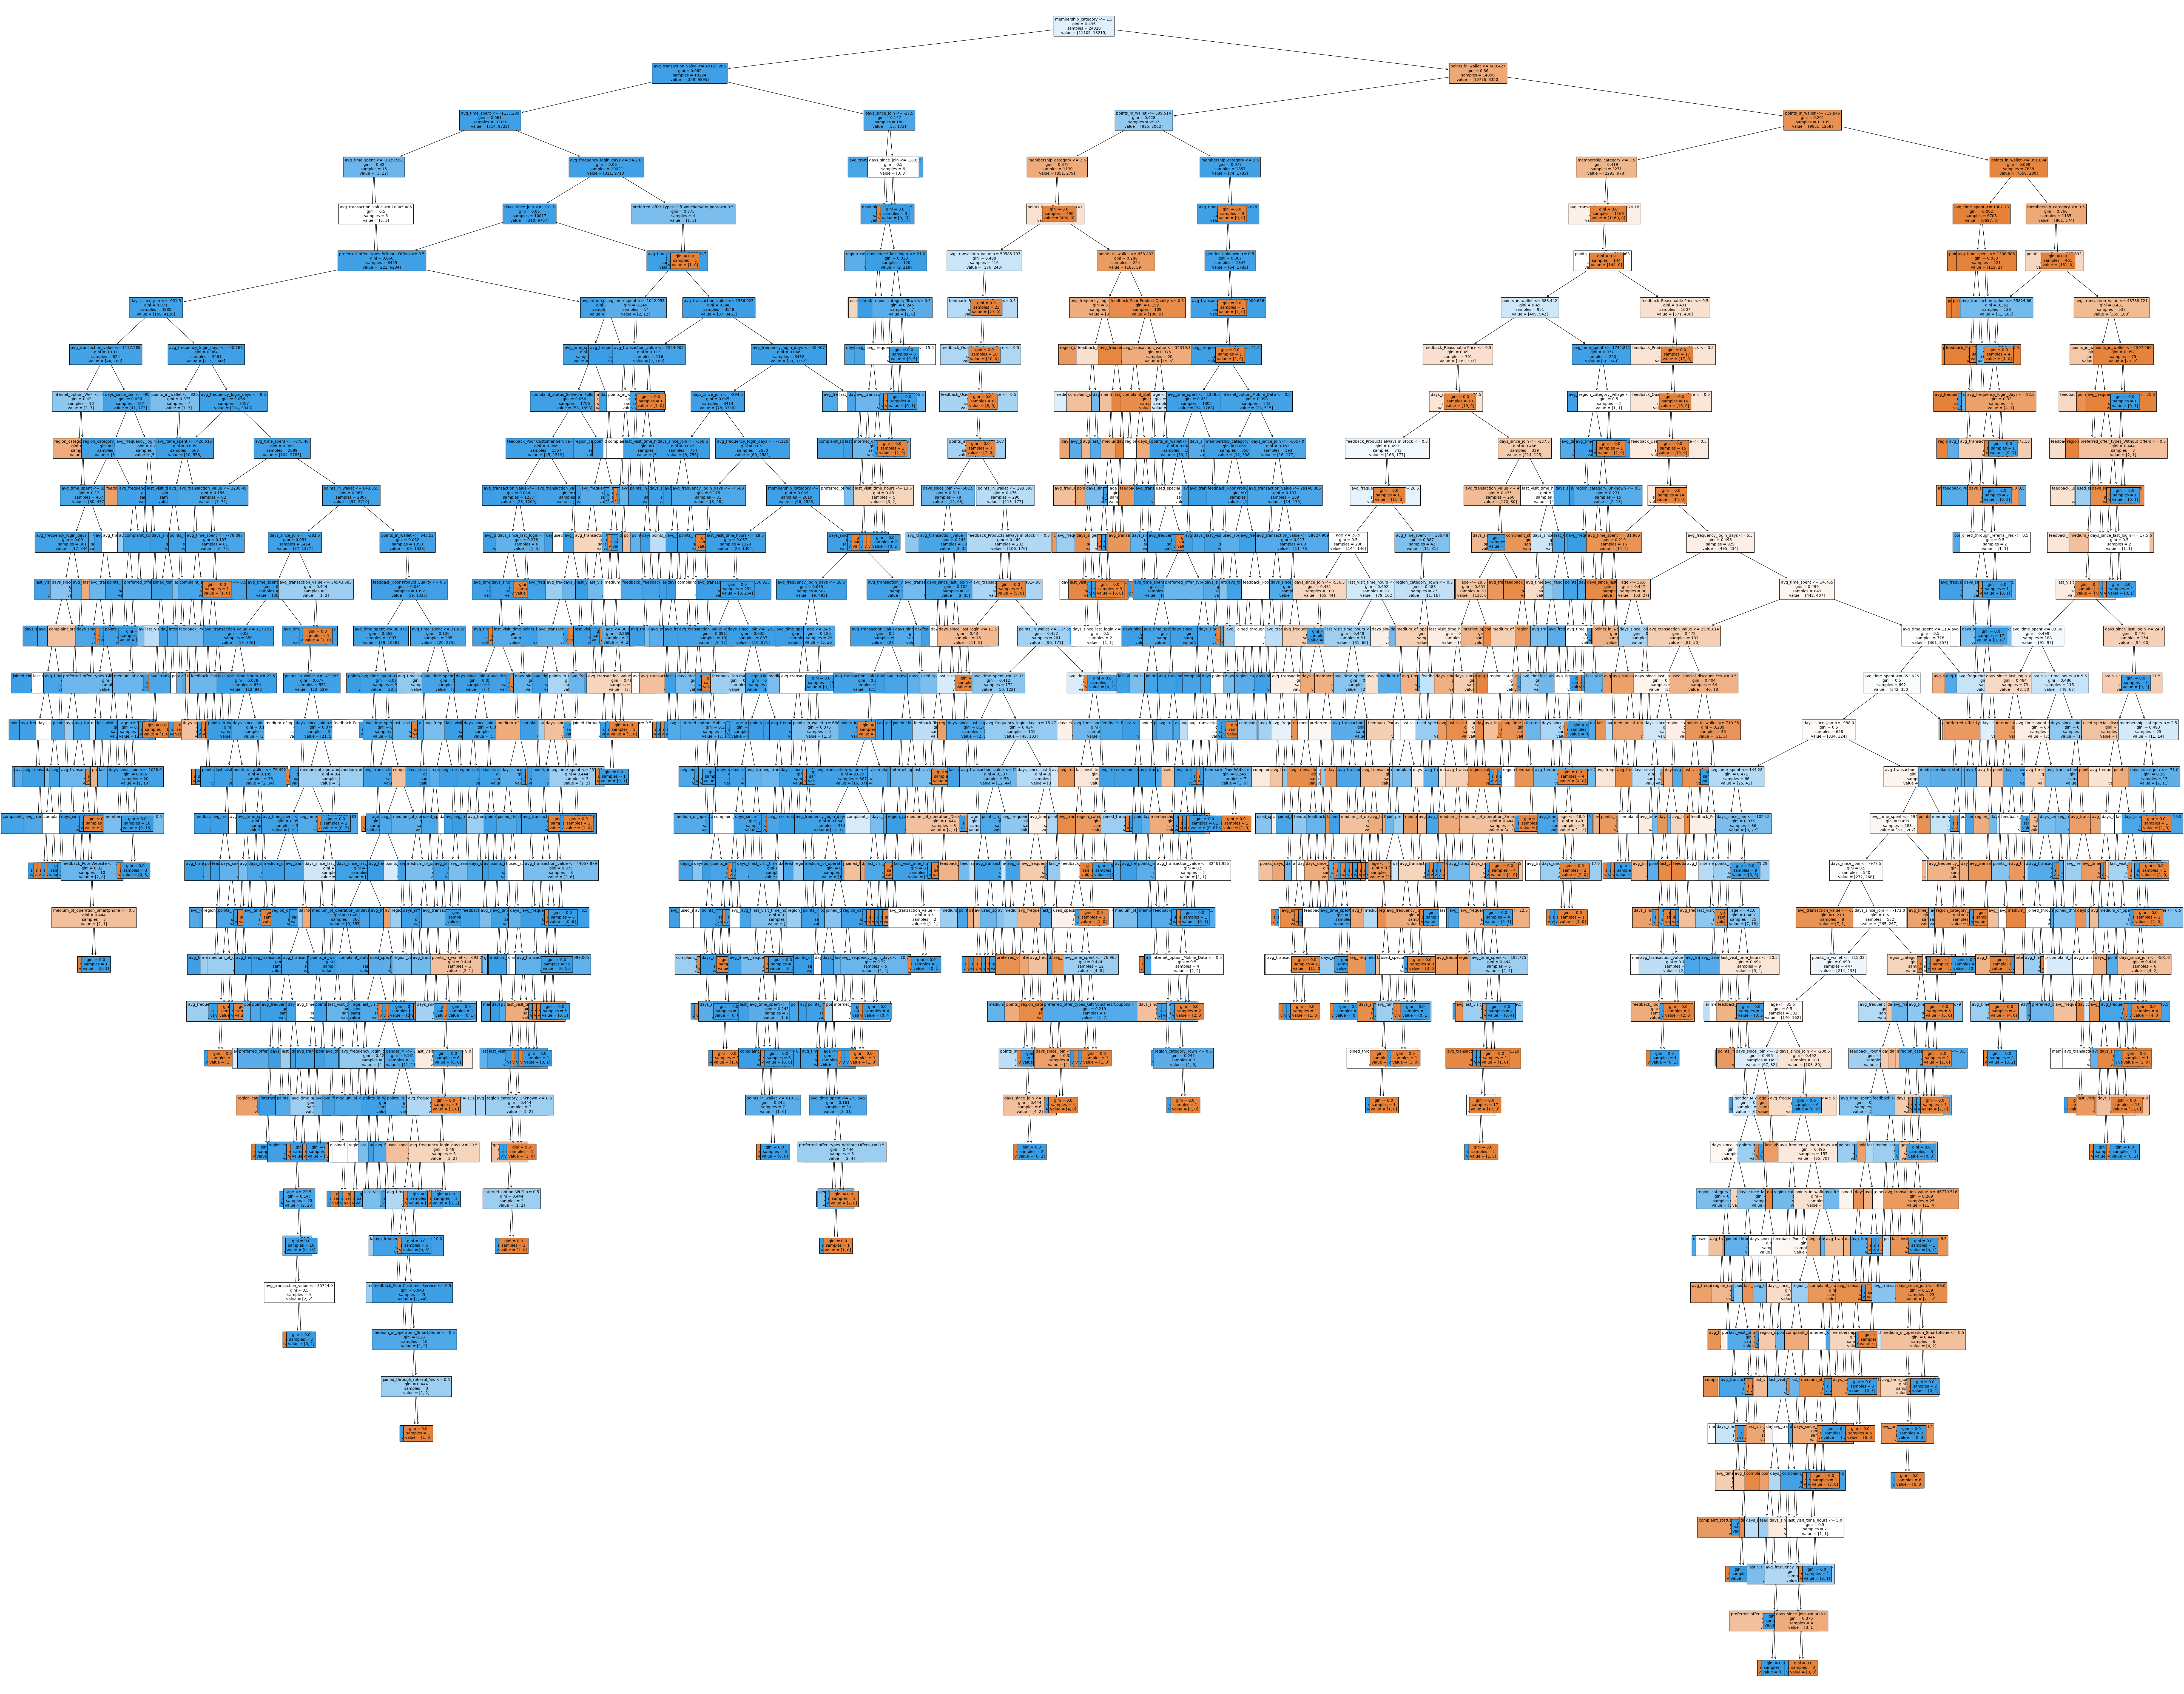

In [ ]:
fig = plt.figure(figsize=(100,80))
dectree_plot = plot_tree(clf,feature_names=features, filled=True,fontsize= 10)

# Hyperparameter tuning inclusive cross-validation

In [ ]:
# Defining parameter grid (as dictionary)
clf_grid = DecisionTreeClassifier()

param_grid = {
    'max_depth': [1, 3, 6, 9, 25],
    'min_impurity_decrease': [0.001, 0.01, 0.1],
    'min_samples_leaf': [3, 5, 25, 50],
}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(clf_grid,
                  param_grid,
                  cv=5,
                  verbose=5,
                  scoring= ,
                  n_jobs=-1)

# Fit gridsearch object to data
gs.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.851 total time=   0.1s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.848 total time=   0.1s
[CV 3/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.853 total time=   0.1s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.848 total time=   0.1s
[CV 5/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.848 total time=   0.1s
[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.851 total time=   0.1s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.848 total time=   0.1s
[CV 3/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.853 total time=   0.1s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 6, 9, 25],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [3, 5, 25, 50]},
             verbose=5)

In [ ]:
# check parameters after GridSearch
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.924
Best parameters: {'max_depth': 6, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3}


In [ ]:
# Get the best model from the grid search
best_model = gs.best_estimator_

#predict test
y_pred_grid = best_model.predict(X_test)

Report on train set : 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     11105
           1       0.95      0.91      0.93     13215

    accuracy                           0.93     24320
   macro avg       0.92      0.93      0.93     24320
weighted avg       0.93      0.93      0.93     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.92
ROC on test set: 0.97
Report on test set : 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      4860
           1       0.95      0.91      0.93      5536

    accuracy                           0.92     10396
   macro avg       0.92      0.92      0.92     10396
weighted avg       0.92      0.92      0.92     10396



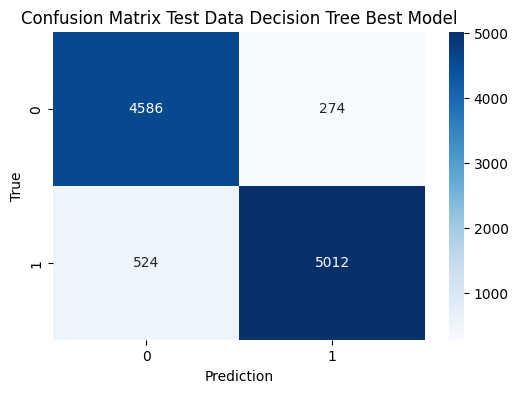

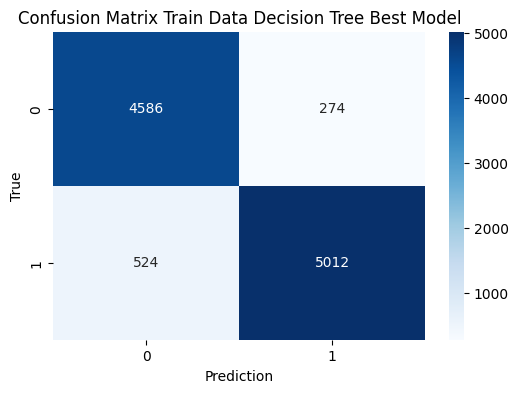

In [128]:
# show prediction scores
prediction_matrices(model = best_model, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "Decision Tree Best Model")



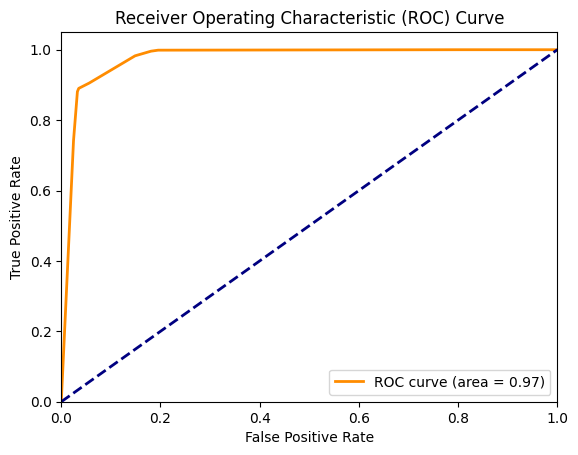

In [ ]:
# ROC Curve
y_pred_roc = best_model.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save model
with open('./model/model_dectree_grid.pkl', 'wb') as file:
    pickle.dump(best_model, file)

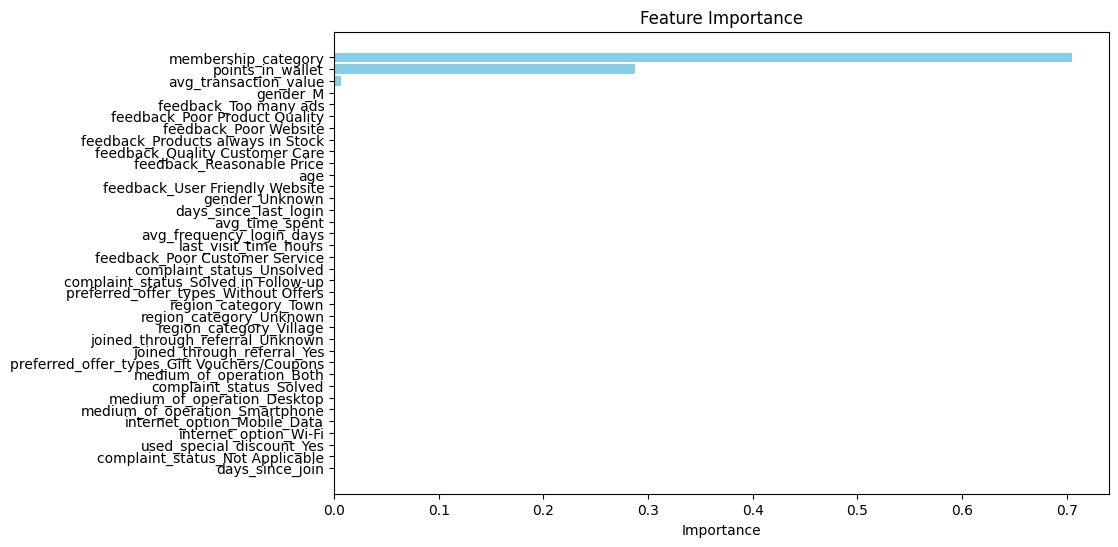

In [ ]:
#feature importance

importances = best_model.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

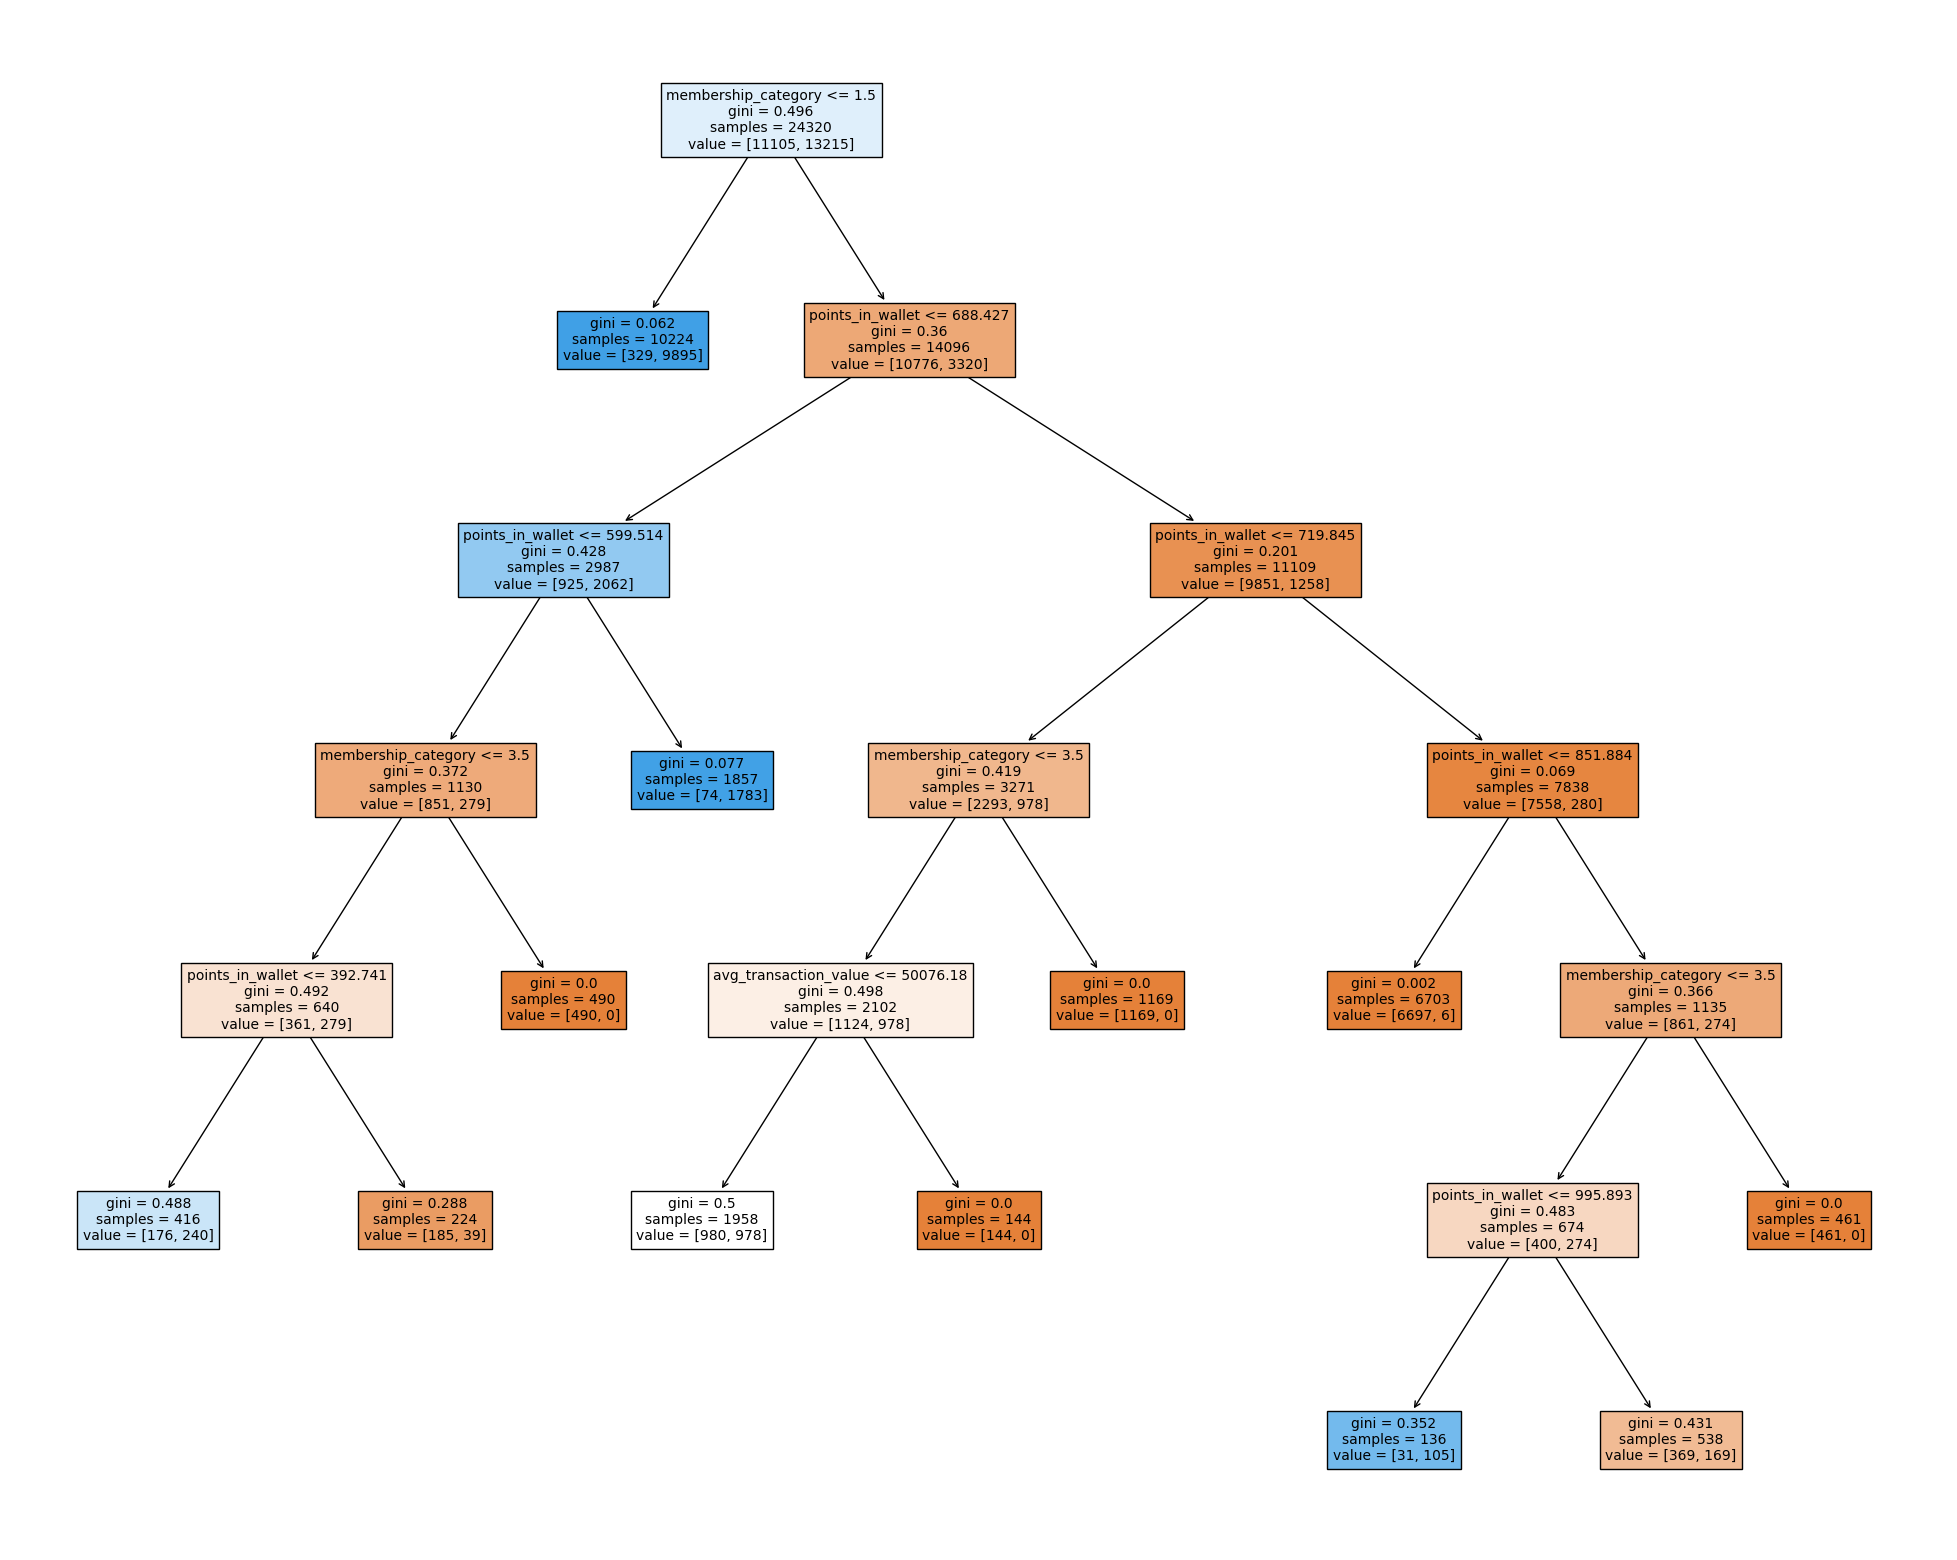

In [ ]:
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(best_model,feature_names=features, filled=True,fontsize= 10)

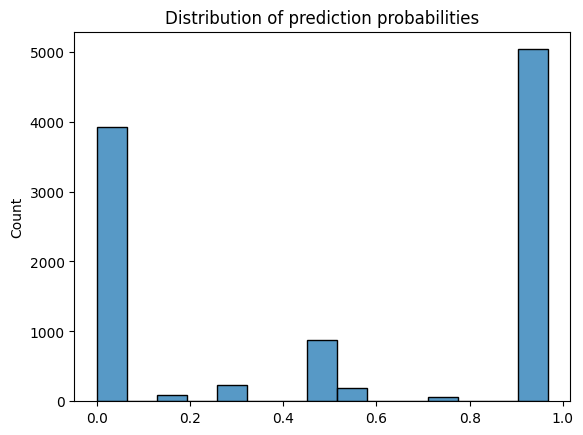

In [ ]:
# get probabilities for predictions on X_test
y_probe = best_model.predict_proba(X_test)

# plot distribution of prediction probabilities
fig = sns.histplot(y_probe[:,1]) #get probabilities for churn_risk_score = 1
plt.title("Distribution of prediction probabilities")
plt.show(fig)


## Add predictions to dataframe for evaluation

In [131]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = best_model.predict(X_test)
df_test_eval['y_pred'] = y_pred

# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = best_model.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval_decision_tree.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval_decision_tree.pkl')

For a vast majority of the predictions, the optimized decision tree results are very close 

- etwas sicherer
- bisschen bessere test prediction
- 2 variablen wirklich bedeutend, eine dritte führt zu leichten verbesserungen
- kaum overfitting --> erfolgreiche regularisierung
- überraschender Weise Feedback nicht wichtig, obwohl bei LogReg ultra wichtig
- cat boost classifier??? Target Encoding?